In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

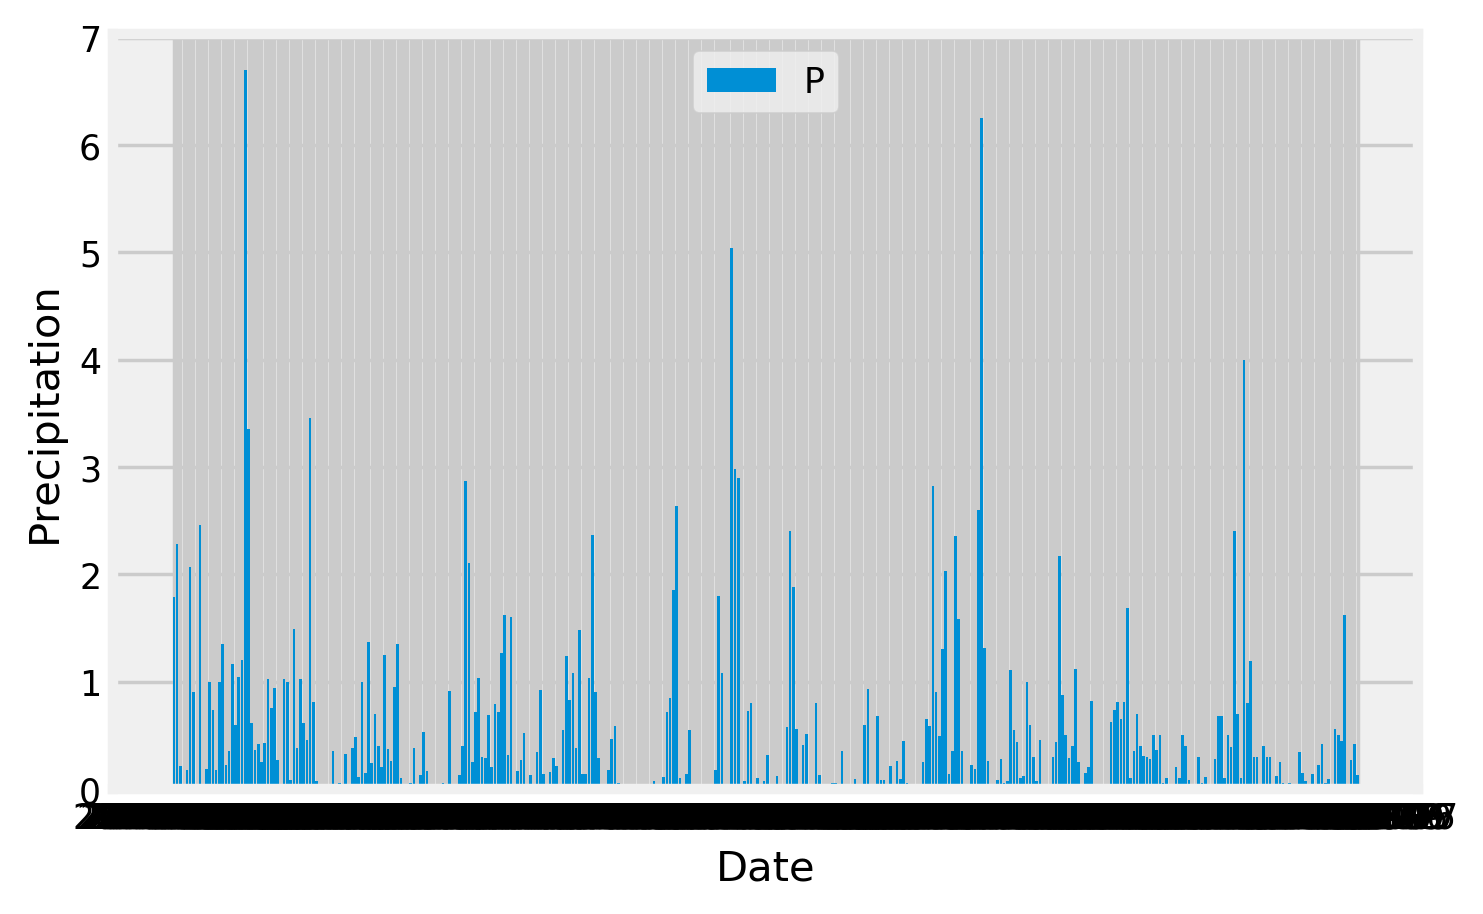

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_results = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df= pd.DataFrame(prcp_results[0:], columns=['date', 'prcp'] )
prcp_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = prcp_df.index.get_values()
y_axis = prcp_df["prcp"]

plt.figure(dpi=250)
plt.bar(x_axis, y_axis, align="center")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend("Precipitation", loc="upper center")
plt.savefig("Percipitation.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Measurement.station).distinct(Measurement.station).count()
total_stations

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)).\
group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
top_station = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == top_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.station == top_station).\
filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()
tobs_df = pd.DataFrame(temp_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


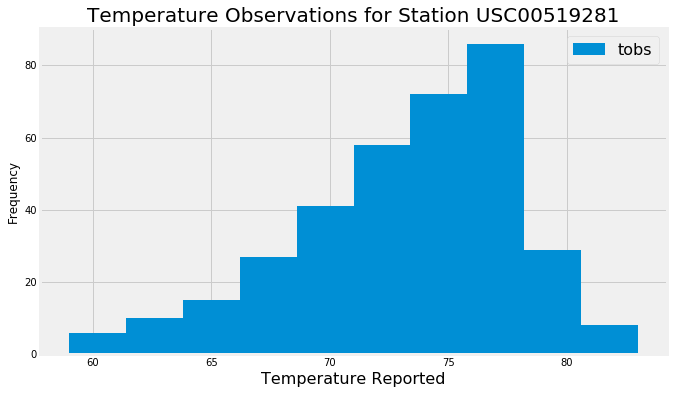

In [16]:
# plot the results as a histogram
tobs_df.plot.hist(by='station', figsize=(10,6))
plt.grid(True)
plt.title("Temperature Observations for Station " + top_station, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("Temp_Observe.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-03-28', '2012-04-17'))

[(58.0, 70.70370370370371, 79.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp= calc_temps('2017-07-31', '2017-08-12')
trip_temp

[(71.0, 78.90566037735849, 83.0)]

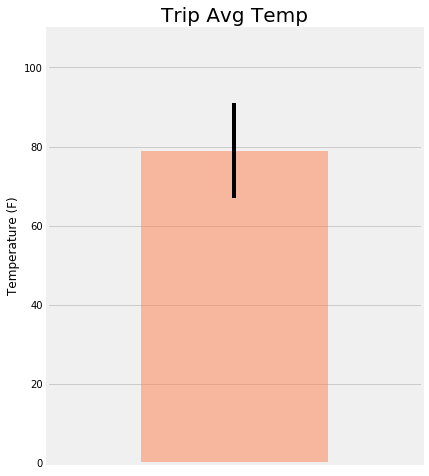

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_temp, columns=['Minimum Temp', 'Average Temp', 'Maximum Temp'])
avg_temp = trip_df['Average Temp']
min_max_temp = trip_df.iloc[0]['Maximum Temp'] - trip_df.iloc[0]['Minimum Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylim(top=110)
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.grid(True)
plt.savefig("Trip_Temp_Sum.png")
plt.show()

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_data = session.query(Station.station,
                 func.sum(Measurement.prcp),
                 Station.name,
                 Station.elevation,                                    
                 Station.latitude,
                 Station.longitude).\
filter(Measurement.station == Station.station).\
filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
group_by(Station.station).\
order_by(func.sum(Measurement.prcp).desc())

for row in rain_data:
    print(str(row[0]) + " " + str(row[1]) + " " + str(row[2]) + " " + str(row[3]) + " " + str(row[4]) + " " + str(row[5]))

USC00516128 147.81000000000006 MANOA LYON ARBO 785.2, HI US 152.4 21.3331 -157.8025
USC00519281 70.03000000000003 WAIHEE 837.5, HI US 32.9 21.45167 -157.84888999999998
USC00513117 48.510000000000026 KANEOHE 838.1, HI US 14.6 21.4234 -157.8015
USC00519523 38.01 WAIMANALO EXPERIMENTAL FARM, HI US 19.5 21.33556 -157.71139
USC00514830 33.239999999999995 KUALOA RANCH HEADQUARTERS 886.9, HI US 7.0 21.5213 -157.8374
USC00519397 16.089999999999986 WAIKIKI 717.2, HI US 3.0 21.2716 -157.8168
USC00517948 4.59 PEARL CITY, HI US 11.9 21.3934 -157.9751


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
